In [140]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from iads.recommandation.prediction import get_cosine_matrix, get_kernel_matrix
from sklearn.cluster import SpectralCoclustering

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [141]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,date_published,title_review,title,note,author,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020,le festival de Michoacan,Mariposas,7.0,morlockbob,mariposas


In [142]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,Nombre d'avis,Note,categories,description,titre,_id,creators,illustrators,editors,distributors,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,7.58,NaN,marvel united unir contre super vilain red sku...,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,45.0,0,1,1,1,0,1
1,33.0,7.39,NaN,annee printemps million papillon monarque quit...,Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,60.0,0,1,1,0,1,1


In [143]:
nb_desc_isna = len(df_jeux[df_jeux["description"].isna()])
nb_jeux = len(df_jeux)
print(nb_desc_isna, "descriptions manquantes sur", nb_jeux )
print(f"Soit {round((nb_desc_isna/nb_jeux)*100,3)}%")

1955 descriptions manquantes sur 16873
Soit 11.587%


In [144]:
desc_notna = df_jeux["description"].notna()
cat_notna = df_jeux["categories"].notna()

df_jeux_nona = df_jeux[desc_notna & cat_notna].reset_index(drop=True)

In [145]:
df_jeux_nona.shape

(12306, 17)

# II. Descriptions

Créer une matrice de similarité pondérée sur plusieurs caractéristiques des les jeux :

In [176]:
col_weights = {"'description'": 3,
            "'categories'":1} 

- Avec cosine : 

In [177]:
cosine_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_cosine_matrix(df_jeux_nona, eval(col))
    cosine_matrix += similarity_matrix * weight

100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


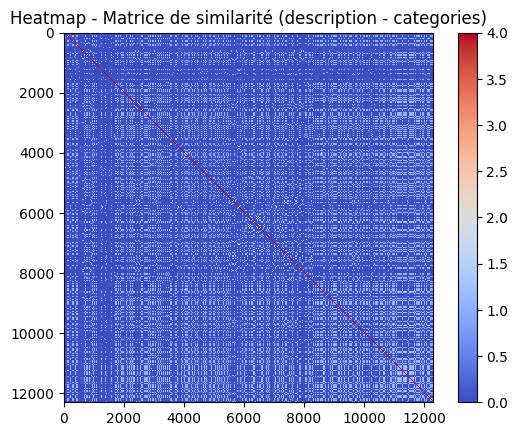

In [178]:
plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap - Matrice de similarité (description - categories)')
plt.colorbar()
plt.show()

In [179]:
cosine_matrix.shape

(12306, 12306)

- Kernel linear 

In [180]:
linear_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "linear")
    linear_matrix += similarity_matrix * weight

100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


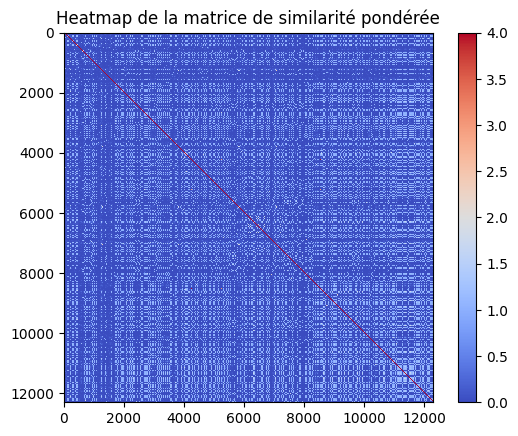

In [181]:
plt.imshow(linear_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

- rbf

In [182]:
rbf_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "rbf")
    rbf_matrix += similarity_matrix * weight

100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


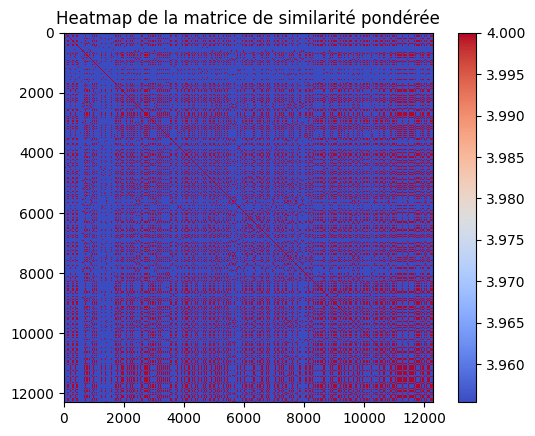

In [183]:
plt.imshow(rbf_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

# III. Recommandation

In [184]:
title = ["Golden Horde", "Troyes Dice"]

In [185]:
df_jeux_nona[df_jeux_nona["titre"].isin(title)][['titre', 'description', 'categories']]

,titre,description,categories
2,Troyes Dice,troyes dice invite decouvrir histoire ville tr...,dé carte
12302,Golden Horde,golden horde simulation simple rapide bataille...,guerre


In [175]:
def basic_recommand_games(matrix, df, title, nb_games=10):
    idx = df[df['titre'] == title].index[0]

    sim_scores = list(enumerate(matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [(i[0], i[1]) for i in sim_scores if i[0] != idx][:nb_games]

    df_recommanded = df.iloc[[i[0] for i in sim_scores]][['titre', 'description','categories']]
    df_recommanded['score_similarite'] = [i[1] for i in sim_scores]

    return df_recommanded

basic_recommand_games(cosine_matrix, df_jeux_nona, title[0]).head(3)


,titre,description,categories,score_similarite
12093,Zürich 1799,bataille systeme jour gloire initier vae victi...,guerre,1.684267
3010,La Bérézina 1812,bataille systeme jour gloire initier vae victi...,guerre,1.642768
5711,Tide of Iron : Fury of the Bear,extension tid of iron,guerre,1.609665


In [186]:
basic_recommand_games(linear_matrix, df_jeux_nona, title[1]).head(3)

,titre,description,categories,score_similarite
2674,Troyes,editeur devenir veritabl tendance marche presq...,dé carte,1.449172
2361,Blackrock City,blackrock city mettre puiser poker pervers jou...,dé carte,1.405676
1382,Barbarossa,barbarossa carte type construction deck buildi...,dé carte,1.356633
